# 분류 - 신용카드 사기검출

1. 데이터 로드 및 확인
    
    1.1 &nbsp;라이브러리 및 데이터 불러오기  
    1.2 &nbsp;데이터 확인  
    1.3 &nbsp;타겟 데이터 확인  
    1.4 &nbsp;결측치 및 이상치 확인  
    
2. 데이터 전처리
    
    2.1 &nbsp;전처리 함수 정의  
    2.2 &nbsp;Train/Test 데이터 분리  
    2.3 &nbsp;SMOTE 적용  
    2.4 &nbsp;평가 함수 정의
    
3. 모델 비교 및 선택
    
    3.1 &nbsp;LogisticRegression  
    3.2 &nbsp;LightGBM  
    3.3 &nbsp;XGBoost  
    3.4 &nbsp;RandomFores  
    3.5 &nbsp;DecisionTree  
    3.6 &nbsp;KNN  
    3.7 &nbsp;AdaBoost  
    3.8 &nbsp;Baseline 모델 성능 비교
    
4. 하이퍼파라미터 튜닝
    
    4.1 &nbsp;GridSearch: LightGBM  
    4.2 &nbsp;GridSearch: XGBoost  
    4.3 &nbsp;RandomSearch: LightGBM  
    4.4 &nbsp;RandomSearch: XGBoost  
    4.5 &nbsp;최적의 Threshold 찾기
    
5. Submission


<br>

## 1. 데이터 로드 및 확인

### 1.1 &nbsp;라이브러리 및 데이터 불러오기

In [ ]:
# SMOTE 패키지 설치
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DS/ML/train_creditcard.csv')
test = pd.read_csv('/content/drive/MyDrive/DS/ML/test_creditcard.csv')

<br>

### 1.2 &nbsp;데이터 확인

In [ ]:
print(train.shape)
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(test.shape)
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,170883,120396.0,-2.410892,-1.264333,-0.787460,-0.212152,1.139859,-2.030200,0.533818,-0.194852,...,-0.558831,-0.076699,0.054816,-1.243901,0.147148,0.974330,1.309377,0.083660,-0.611166,124.98
1,170884,120396.0,-1.394526,0.284790,2.979226,0.362345,-1.344546,2.278858,-1.836101,-1.797895,...,-0.807798,1.945416,-0.539926,-0.446763,-0.521142,0.405680,-0.149237,0.458944,-0.071516,50.00
2,170885,120396.0,0.140378,0.989574,-0.506447,0.480553,1.407763,0.371637,0.811775,0.067702,...,0.120841,0.385872,1.302941,-0.177157,-0.192410,-0.724567,-0.433276,0.540947,0.323866,8.69
3,170886,120396.0,-1.303150,0.187865,0.944395,-1.277834,1.236744,-1.301696,1.402234,-0.558914,...,-0.251346,-0.274175,-0.656826,-0.164985,0.001284,-0.001842,-0.024050,-0.436872,0.051705,59.99
4,170887,120396.0,1.947883,-1.095332,-1.392121,-0.600598,-0.320840,0.048953,-0.443486,-0.081011,...,-0.293448,-0.250594,-0.385151,0.099030,0.221922,-0.212846,0.586637,-0.071616,-0.045475,119.97


In [ ]:
# id=170882 를 기점으로 그 뒤 시점으로 자름
train["id"].max(), test["id"].min()

(170882, 170883)

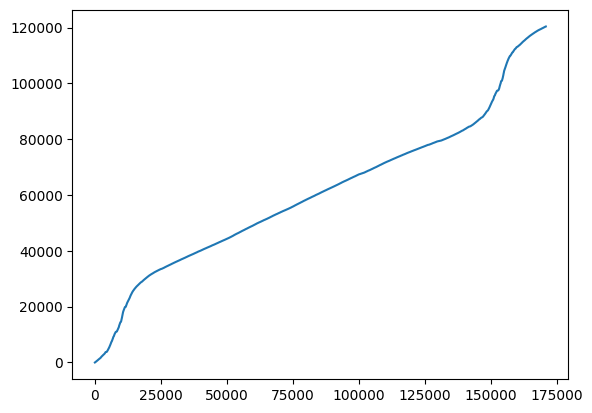

In [ ]:
# id가 시간 순서인지 확인
import matplotlib.pyplot as plt
plt.plot(train['id'], train['Time'])

그래프가 계단 없이 우상향하고 있으므로 id는 Time의 순서를 그대로 따라가는 구조이다.  

따라서 id를 기준으로 나누는 것은 곧 시간 순 분할(time-based split)이라고 판단할 수 있고, id를 기준으로 나눔으로써 시계열 분할 효과를 기대할 수 있다.



<br>

In [ ]:
# 전체 데이터에서 학습 데이터의 비율 확인
print(len(train), len(test))
len(train)/(len(train) + len(test))

170883 113923


0.5999978933028096

시계열 기반 분할에서 train/test 비율이 적절한지 확인할 수 있다.

<br>

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170883 entries, 0 to 170882
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      170883 non-null  int64  
 1   Time    170883 non-null  float64
 2   V1      170883 non-null  float64
 3   V2      170883 non-null  float64
 4   V3      170883 non-null  float64
 5   V4      170883 non-null  float64
 6   V5      170883 non-null  float64
 7   V6      170883 non-null  float64
 8   V7      170883 non-null  float64
 9   V8      170883 non-null  float64
 10  V9      170883 non-null  float64
 11  V10     170883 non-null  float64
 12  V11     170883 non-null  float64
 13  V12     170883 non-null  float64
 14  V13     170883 non-null  float64
 15  V14     170883 non-null  float64
 16  V15     170883 non-null  float64
 17  V16     170883 non-null  float64
 18  V17     170883 non-null  float64
 19  V18     170883 non-null  float64
 20  V19     170883 non-null  float64
 21  V20     17

In [ ]:
train.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,...,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000,170883.000000
mean,85441.000000,61091.567090,-0.169838,0.040771,0.493037,0.117429,-0.176102,0.058235,-0.080669,0.032227,...,-0.028287,-0.083744,-0.022450,0.009008,0.092269,0.012603,0.002093,0.002445,87.336704,0.002107
std,49329.817362,27828.109419,1.850529,1.610874,1.383241,1.371910,1.338609,1.295123,1.208518,1.227630,...,0.743713,0.667318,0.584508,0.598760,0.465505,0.490660,0.391951,0.307315,245.954429,0.045851
min,0.000000,0.000000,-56.407510,-72.715728,-33.680984,-5.519697,-42.147898,-26.160506,-43.557242,-73.216718,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,42720.500000,41216.500000,-0.986667,-0.539174,-0.064747,-0.743475,-0.828769,-0.691129,-0.586314,-0.162638,...,-0.230722,-0.546777,-0.170294,-0.332459,-0.195933,-0.330346,-0.065125,-0.027054,5.480000,0.000000
50%,85441.000000,60776.000000,-0.183560,0.109679,0.623352,0.124307,-0.226228,-0.202634,-0.031932,0.056664,...,-0.054462,-0.066786,-0.036211,0.059474,0.135662,-0.058966,0.008693,0.021152,21.890000,0.000000
75%,128161.500000,78622.000000,1.184446,0.804221,1.297352,0.937632,0.374445,0.449200,0.462616,0.350995,...,0.128337,0.363165,0.098707,0.415860,0.399458,0.272938,0.089727,0.078302,76.720000,0.000000
max,170882.000000,120396.000000,2.439207,22.057729,9.382558,16.875344,34.801666,22.529298,36.677268,20.007208,...,27.202839,10.503090,19.002942,4.022866,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


### 1.3 &nbsp;타겟 데이터 확인

타겟(label)인 Class 컬럼의 분포를 확인하여 데이터 불균형 여부를 진단한다.  
사기 거래(Class=1)가 매우 적은 비율을 차지하는 불균형 데이터임을 확인한다.

In [ ]:
# Class 분포 확인
train["Class"].value_counts(normalize=True)*100

,proportion
Class,
0,99.78933
1,0.21067


사기 클래스(1)는 약 0.2% 수준임을 확인할 수 있다.  
클래스 불균형이 존재하므로 Precision과 Recall의 균형도 중요하게 고려해야 한다.

<br>

사기 거래가 특정 사용자 ID(id)에 집중되어 있는지 확인하기 위해 ID별 사기 거래 건수를 확인한다.

In [ ]:
train[train['Class'] == 1].groupby('id')['Amount'].count()

,Amount
id,
541,1
623,1
4920,1
6108,1
6329,1
...,...
157918,1
163149,1
163586,1


<br>

### 1.4 &nbsp;결측치 및 이상치 확인

In [ ]:
# 결측치 확인
train.isnull().sum().sum()

np.int64(0)

In [ ]:
# 중복값 확인
train[train.duplicated() == 1]

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


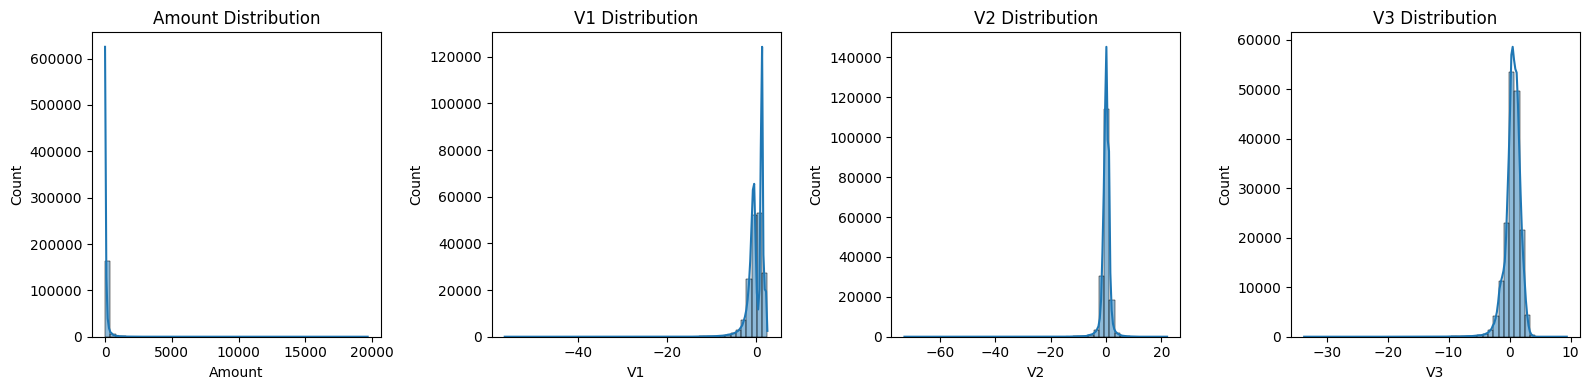

In [ ]:
# 주요 수치형 변수 분포 확인
plt.figure(figsize=(16, 4))
for i, col in enumerate(['Amount', 'V1', 'V2', 'V3']):
    plt.subplot(1, 4, i+1)
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

Amount는 분포과 왜곡되어 있으므로 로그 변환이 필요해 보인다.

V1 ~ V3 등의 변수들은 어느정도 정규분포에 유사한 형태를 띄는데, PCA로 변환된 값으로 예상할 수 있고 별도 스케일링이 필요 없다고 판단된다.

<br>

중요한 피처 중 하나인 Amount가 타깃 값과 어떤 관계를 가질 수 있는지 확인해 본다.

In [ ]:
# 사기/정상 거래 간 Amount(거래 금액) 평균 비교
fraud = train[train['Class'] == 1]
normal = train[train['Class'] == 0]

print("사기 거래의 Amount 평균:", fraud['Amount'].mean())
print("정상 거래의 Amount 평균:", normal['Amount'].mean())

사기 거래의 Amount 평균: 111.57672222222222
정상 거래의 Amount 평균: 87.28552963529847


사기 거래가 평균적으로 더 큰 금액을 가지는 경향이 있음을 알 수 있다.  
이 차이를 모델이 활용할 수 있도록 이후 로그 변환을 수행하겠다.

<br>


Class와 다른 피처들 간의 관계를 살펴보고 유의미한 피처를 추려낼 수 있을지 확인해 본다.

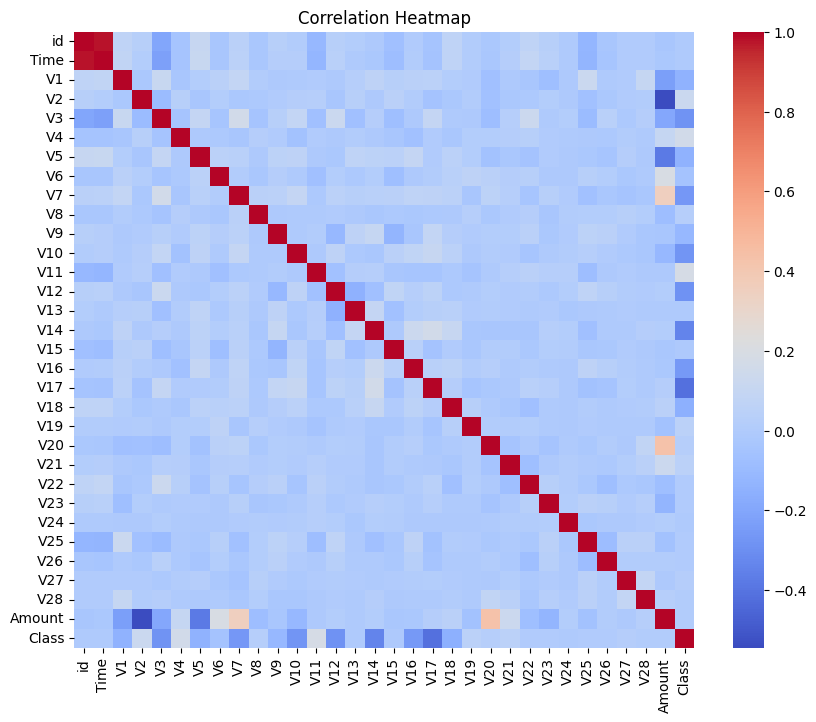

In [ ]:
# 이상치 확인: 타겟값과 각 피처의 상관계수를 비교하여 이상치 탐지
plt.figure(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

Class와 다른 변수들 간 상관계수가 전반적으로 낮은 편이지만,
일부 변수들은 상대적으로 높은 상관관계를 보인다.

강한 음의 상관관계를 보이는 V12, V14, V17 컬럼의 이상치 여부를 확인해 본다.

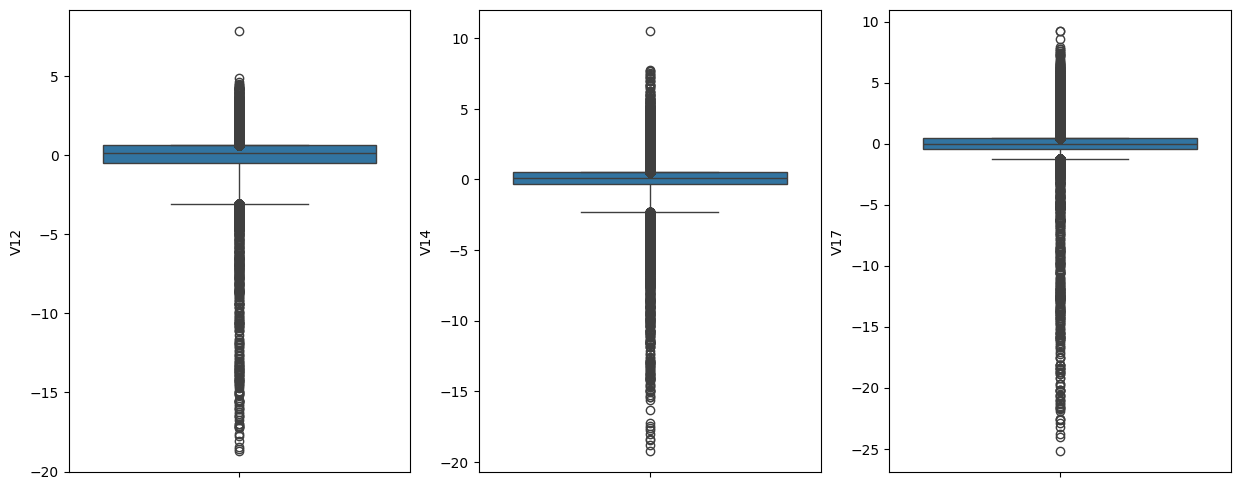

In [ ]:
# 컬럼별 이상치 시각화
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=train['V12'], whis=[1.5, 1.5])

plt.subplot(1, 3, 2)
sns.boxplot(y=train['V14'], whis=[1.5, 1.5])

plt.subplot(1, 3, 3)
sns.boxplot(y=train['V17'], whis=[1.5, 1.5])

plt.show()

In [ ]:
def count_outliers(column):
    q1 = train[column].quantile(0.25)
    q3 = train[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train[(train[column] < lower_bound) | (train[column] > upper_bound)]
    return len(outliers)

# 계산 대상 컬럼
cols = ['V12', 'V14', 'V17']

# 이상치 개수 출력
for col in cols:
    print(f"{col} 이상치 개수:", count_outliers(col))

V12 이상치 개수: 11267
V14 이상치 개수: 9455
V17 이상치 개수: 4693


세 변수 모두 중앙값은 0 부근에 있고, IQR 범위를 벗어난 이상치가 아래쪽(음의 방향)에 집중되어 있는 전형적인 right-skewed 분포 구조를 갖고 있다.

| 항목            | V12      | V14               | V17      |
| ------------- | -------- | ----------------- | -------- |
| 이상치 분포 범위     | -20까지 분포 | -20까지 깊고 조밀   | -25까지 분포 |
| 박스 내부(IQR) 크기 | 중간 정도    | 매우 얇음 (분산 작음) | 매우 얇음 |
| 이상치 개수        | 많음       | 매우 많고 조밀      | 많음       |
| Class와 상관성    | 있음       | 높음            | 높음   |

<br>

- Class(사기 여부)와의 상관관계
    - V14는 Class와 비교적 강한 음의 상관관계를 보임  
→ 사기 여부를 구분짓는 데 있어 모델에 영향력 있는 피처

- 이상치 분포 특성
    - V12나 V17은 극단치가 많지만, V12는 사기거래와의 상관성이 비교적 낮고 V17은 음수방향으로 퍼져 있지만 영향이 제한적일 수 있다.

Class와의 상관관계가 높고, 이상치가 모델에 부정적인 영향을 줄 가능성이 큰 V1 피처에 대해 이상치 제거를 수행한다.

이후 모델 튜닝에서 영향 여부를 판단하고 V12, V17 피처에 대한 이상치 처리를 고려할 수 있다.

<br>
<br>

## 2. 데이터 전처리

신용카드 사기 검출 데이터의 특성을 반영하여 전처리한다.


1. 전처리 함수 정의

    - Amount 피처를 로그 스케일링 및 분석에 불필요한 피처(Time, Amount, id)를 제거 후 V14 피처 기준 IQR 기반 이상치를 제거한다.

2. Train/Test 데이터 분리

    - Stratify 옵션을 사용하여 라벨 비율을 유지한 채 학습/테스트 데이터를 나눈다.

3. SMOTE 적용

    - 클래스 불균형 문제를 해결하기 위해 소수 클래스 데이터를 오버샘플링한다.

4. 평가 함수 정의

    - 다양한 모델의 성능을 공통 기준으로 비교할 수 있도록 커스텀 평가 함수를 정의한다.

<br>

### 2.1 &nbsp;전처리 함수 정의

- 이상치 판별 함수

In [ ]:
def get_outlier(df=None, column=None, weight=1.5):
    """
    사기 거래(Class==1) 데이터에서 IQR 기준으로 이상치를 판별하고,
    해당 column에서 정상 범위를 벗어난 인덱스를 반환하는 함수

    Parameters
    ----------
    df : pd.DataFrame
        전체 거래 데이터프레임 (Class 컬럼 포함)
    column : str
        이상치를 판별할 대상 컬럼명
    weight : float, optional
        IQR 범위 조절 계수 (기본값은 1.5, Tukey's Fence 기준)

    Returns
    -------
    outlier_index : pd.Index
        IQR 기반 이상치로 탐지된 데이터의 인덱스 리스트

    Notes
    -----
    - 이상치는 사기 거래(Class==1)를 기준으로 IQR 범위를 계산한다.
    - 이후 해당 column에서 IQR 범위를 벗어난 값을 가진 인덱스를 반환한다.
    - 실제 이상치를 제거/분석할 때는 이 인덱스를 활용해 접근한다.
    """

    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

<br>

- 데이터 전처리 함수

In [ ]:
def get_preprocessed_df(df=None, train=True):
    """
    신용카드 사기 거래 탐지용 데이터 전처리 함수

    Parameters
    ----------
    df : pd.DataFrame
        원본 데이터프레임 (Class, Time, Amount, V1~V28 포함)
    train : bool, optional
        학습 데이터 여부 (기본값: True). 현재는 분기처리에 사용되지 않음.

    Returns
    -------
    df_copy : pd.DataFrame
        전처리된 데이터프레임 (Amount 로그 스케일링 적용, Time/Amount/id 제거, 이상치 제거 포함)

    전처리 단계 설명
    ------------
    1. 입력받은 df를 복사하여 원본 훼손 방지
    2. 'Amount' 피처 엔지니어링
        : 컬럼을 로그 스케일링하여 'Amount_Scaled'로 추가 (가장 앞 열에 삽입)
    3. 'Time', 'Amount', 'id' 컬럼 제거 (모델 성능에 기여하지 않거나 노이즈가 되는 컬럼)
    4. V14 컬럼을 기준으로 IQR 기반 이상치를 탐지하고, 해당 인덱스의 행 제거
        : 사기거래의 통계적 이상값이 모델이 학습해야 할 중요한 특성일 가능성도 고려해야 한다.
    """

    df_copy = df.copy()

    # 로그 스케일링
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)

    # 불필요한 컬럼 제거
    df_copy.drop(['Time', 'Amount', 'id'], axis=1, inplace=True)

    # 이상치 탐지 후 제거
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)

    # # 이상치 탐지 후 제거 - 추가 피처 적용
    # outlier_cols = ['V12', 'V14', 'V17']
    # outlier_index = []
    # for col in outlier_cols:
    #     outlier_index.extend(get_outlier(df=df_copy, column=col, weight=1.5))
    # outlier_index = list(set(outlier_index))
    # df_copy.drop(outlier_index, axis=0, inplace=True)

    return df_copy

<br>

- train/test 데이터 분리 함수

In [ ]:
def get_train_test_dataset(df=None):
    """
    데이터 전처리 후 학습용(train)과 테스트용(test) 데이터로 분리하여 반환하는 함수

    Returns
    -------
    X_train : pd.DataFrame
        학습용 feature 데이터
    X_test : pd.DataFrame
        테스트용 feature 데이터 (성능 평가용)
    y_train : pd.Series
        학습용 타겟 값
    y_test : pd.Series
        테스트용 타겟 값
    """

    df_copy = get_preprocessed_df(df)

    X_features = df_copy.drop('Class', axis=1)  # 타겟 컬럼 명시적 제거
    y_target = df_copy['Class']

    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_target,
        test_size=0.3,
        random_state=0,
        stratify=y_target  # 원본 데이터의 Label 비율 유지
        )

    return X_train, X_test, y_train, y_test

<br>
<br>

### 2.2 &nbsp;Train/Test 데이터 분리

전처리된 데이터에서 feature/label을 분리한 뒤, train_test_split()을 사용해 학습용/테스트용 데이터로 나눈다.
이때 stratify 옵션을 지정하여 클래스 비율(Class imbalance)을 유지한 상태로 데이터를 분할한다.

분할된 후 실제로 학습/테스트 세트의 레이블 비율이 동일하게 유지되는지 확인한다.

In [ ]:
# 데이터 전처리 후, feature/label 분리 후 train/test 셋 분리
X_train, X_test, y_train, y_test = get_train_test_dataset(train)

In [ ]:
# stratify 적용 했기 때문에 원본 데이터의 라벨의 분포 고려되어 나뉨
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print()
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Class
0    99.790998
1     0.209002
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
Class
0    99.791277
1     0.208723
Name: count, dtype: float64


<br>

### 2.3 &nbsp;SMOTE 적용

SMOTE를 적용해서 데이터 불균형 문제를 완화시킨다.

>SMOTE(Synthetic Minority Over-sampling Technique)는 소수 클래스(사기 거래)에 대해 기존 소수 클래스 샘플들을 바탕으로 인공적으로 새로운 데이터를 생성하는 오버샘플링 기법이다. 소수 클래스의 특징을 보존하면서 데이터 분포를 균형 있게 만든다.

클래스 비율을 맞춤으로써 재현율, F1-score, PR-AUC 등의 성능 지표 개선을 기대할 수 있다.

In [ ]:
smote = SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [ ]:
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ", X_train.shape, y_train.shape)
print("\nSMOTE 적용 후 학습용 피처/레이블 데이터 세트: ", X_train_over.shape, y_train_over.shape)
print("\nSMOTE 적용 후 레이블 값 분포: \n", pd.Series(y_train_over).value_counts(normalize=True))

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (119616, 29) (119616,)

SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (238732, 29) (238732,)

SMOTE 적용 후 레이블 값 분포: 
 Class
0    0.5
1    0.5
Name: proportion, dtype: float64


<br>
<br>

### 2.4 &nbsp;평가 함수 정의

- 평가 지표 출력 함수

In [ ]:
def get_clf_eval(y_test, pred, pred_proba=None):
    """
    이진 분류 모델의 주요 성능 지표를 출력하는 평가 함수

    Parameters
    ----------
    y_test : array-like
        실제 레이블 값 (정답)
    pred : array-like
        분류 모델의 예측 결과 (0 또는 1)
    pred_proba : array-like, optional
        클래스 1에 대한 예측 확률 (ROC-AUC 계산용)

    Returns
    -------
    None
        평가 지표를 출력만 하고 반환값은 없음

    출력 내용
    -------
    - 오차 행렬 (Confusion Matrix)
    - 정확도 (Accuracy)
    - 정밀도 (Precision)
    - 재현율 (Recall)
    - F1 스코어
    - ROC-AUC (클래스 1의 예측 확률 기반)
    """

    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    # 예측 확률값이 없는 경우 에러 방지
    roc_auc = roc_auc_score(y_test, pred_proba) if pred_proba is not None else None

    print('오차 행렬')
    print(confusion)
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision: .4f}, 재현율: {recall: .4f}, f1스코어: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')

<br>

- 모델 학습 및 평가 함수

In [ ]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from xgboost import XGBClassifier

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    """
    모델 학습 및 평가 수행 함수 (LightGBM, XGBoost는 early stopping 자동 적용)

    Parameters
    ----------
    model : classifier model object
        학습 및 예측에 사용할 분류 모델 객체
    ftr_train : array-like
        학습용 feature 데이터
    ftr_test : array-like
        테스트용 feature 데이터
    tgt_train : array-like
        학습용 target 값
    tgt_test : array-like
        테스트용 target 값

    Returns
    -------
    없음 (내부에서 평가 결과를 출력함)
    """

    eval_set = [(ftr_train, tgt_train), (ftr_test, tgt_test)]

    # LightGBM 또는 XGBoost의 경우 early stopping 적용
    if isinstance(model, LGBMClassifier):
        model.fit(
            ftr_train, tgt_train,
            eval_set=eval_set,
            eval_metric='auc',
            # 조기 종료 로그, 평가 지표 로그 제거
            callbacks=[early_stopping(stopping_rounds=100, verbose=False), log_evaluation(period=0)]
        )
    elif isinstance(model, XGBClassifier):
        model.fit(
            ftr_train, tgt_train,
            eval_set=eval_set,
            verbose=False
        )
    else:
        # 일반 모델 학습
        model.fit(ftr_train, tgt_train)

    # 예측 및 평가
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

<br>
<br>

## 3. 모델 비교 및 선택

- 머신러닝 분류 모델들을 하이퍼파라미터 튜닝 없이 default parameters 상태로 학습시킨 후
- 각 모델의 전반적인 예측 성능을 비교하고자 진행한다.

In [ ]:
# 모델 객체 생성

log_clf = LogisticRegression(max_iter=1000)  # 수렴 실패 방지

lgbm_clf = LGBMClassifier(boost_from_average=False,  # 불균형 데이터이므로 모델 자체 학습 유도
                          # force_row_wise=True,     # 멀티스레딩 경고 로그 제거
                          random_state=42,
                          n_jobs=-1,
                          verbosity=-1
                         )

xgb_clf = XGBClassifier(eval_metric='auc',
                        early_stopping_rounds=10,
                        use_label_encoder=False,
                        random_state=42,
                        n_jobs=-1
                       )

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
dt_clf = DecisionTreeClassifier(random_state=42)
knn_clf  = KNeighborsClassifier()
ada_clf = AdaBoostClassifier(random_state=42)

<br>

### 3.1 &nbsp;LogisticRegression

In [ ]:
# LogisticRegression - 기존 블균형 훈련 데이터
get_model_train_eval(model=log_clf,
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test)

오차 행렬
[[51145    12]
 [   40    67]]
정확도: 0.9990, 정밀도:  0.8481, 재현율:  0.6262, f1스코어: 0.7204
ROC-AUC: 0.9666


In [ ]:
# LogisticRegression - SMOTE 적용한 오버샘플링 데이터
get_model_train_eval(model = log_clf,
                     ftr_train=X_train_over,
                     ftr_test=X_test,
                     tgt_train=y_train_over,
                     tgt_test=y_test
                    )

오차 행렬
[[50130  1027]
 [   10    97]]
정확도: 0.9798, 정밀도:  0.0863, 재현율:  0.9065, f1스코어: 0.1576
ROC-AUC: 0.9755


<br>

### 3.2 &nbsp;LightGBM

In [ ]:
# LightGBM - 기존 블균형 훈련 데이터
get_model_train_eval(model = lgbm_clf,
                     ftr_train=X_train,
                     ftr_test=X_test,
                     tgt_train=y_train,
                     tgt_test=y_test
                    )

오차 행렬
[[51150     7]
 [   17    90]]
정확도: 0.9995, 정밀도:  0.9278, 재현율:  0.8411, f1스코어: 0.8824
ROC-AUC: 0.9756


In [ ]:
# LightGBM - SMOTE 적용한 오버샘플링 데이터
get_model_train_eval(model = lgbm_clf,
                     ftr_train=X_train_over,
                     ftr_test=X_test,
                     tgt_train=y_train_over,
                     tgt_test=y_test
                     )

오차 행렬
[[51110    47]
 [   16    91]]
정확도: 0.9988, 정밀도:  0.6594, 재현율:  0.8505, f1스코어: 0.7429
ROC-AUC: 0.9834


<br>

### 3.3 &nbsp;XGBoost

In [ ]:
# XGBoost - 기존 블균형 훈련 데이터
get_model_train_eval(model = xgb_clf,
                    ftr_train=X_train,
                    ftr_test=X_test,
                    tgt_train=y_train,
                    tgt_test=y_test
                    )

오차 행렬
[[51150     7]
 [   18    89]]
정확도: 0.9995, 정밀도:  0.9271, 재현율:  0.8318, f1스코어: 0.8768
ROC-AUC: 0.9885


In [ ]:
# XGBoost - SMOTE 적용한 오버샘플링 데이터
get_model_train_eval(model=xgb_clf,
                     ftr_train=X_train_over,
                     ftr_test=X_test,
                     tgt_train=y_train_over,
                     tgt_test=y_test
                     )

오차 행렬
[[50755   402]
 [   12    95]]
정확도: 0.9919, 정밀도:  0.1911, 재현율:  0.8879, f1스코어: 0.3146
ROC-AUC: 0.9826


<br>

### 3.4 RandomForest

In [ ]:
# RandomForest - 기존 블균형 훈련 데이터
get_model_train_eval(model = rf_clf,
                    ftr_train=X_train,
                    ftr_test=X_test,
                    tgt_train=y_train,
                    tgt_test=y_test
                    )

오차 행렬
[[51152     5]
 [   19    88]]
정확도: 0.9995, 정밀도:  0.9462, 재현율:  0.8224, f1스코어: 0.8800
ROC-AUC: 0.9422


In [ ]:
# RandomForest - SMOTE 적용한 오버샘플링 데이터
get_model_train_eval(model=rf_clf,
                     ftr_train=X_train_over,
                     ftr_test=X_test,
                     tgt_train=y_train_over,
                     tgt_test=y_test
                     )

오차 행렬
[[51150     7]
 [   16    91]]
정확도: 0.9996, 정밀도:  0.9286, 재현율:  0.8505, f1스코어: 0.8878
ROC-AUC: 0.9793


<br>

### 3.5 &nbsp;DecisionTree

In [ ]:
# DecisionTree - 기존 블균형 훈련 데이터
get_model_train_eval(model = dt_clf,
                    ftr_train=X_train,
                    ftr_test=X_test,
                    tgt_train=y_train,
                    tgt_test=y_test
                    )

오차 행렬
[[51129    28]
 [   23    84]]
정확도: 0.9990, 정밀도:  0.7500, 재현율:  0.7850, f1스코어: 0.7671
ROC-AUC: 0.8922


In [ ]:
# Decision - SMOTE 적용한 오버샘플링 데이터
get_model_train_eval(model=dt_clf,
                     ftr_train=X_train_over,
                     ftr_test=X_test,
                     tgt_train=y_train_over,
                     tgt_test=y_test
                     )

오차 행렬
[[51038   119]
 [   20    87]]
정확도: 0.9973, 정밀도:  0.4223, 재현율:  0.8131, f1스코어: 0.5559
ROC-AUC: 0.9054


<br>

### 3.6 &nbsp;KNN

In [ ]:
# KNN - 기존 블균형 훈련 데이터
get_model_train_eval(model = knn_clf,
                    ftr_train=X_train,
                    ftr_test=X_test,
                    tgt_train=y_train,
                    tgt_test=y_test
                    )

오차 행렬
[[51148     9]
 [   23    84]]
정확도: 0.9994, 정밀도:  0.9032, 재현율:  0.7850, f1스코어: 0.8400
ROC-AUC: 0.9251


In [ ]:
# KNN - SMOTE 적용한 오버샘플링 데이터
get_model_train_eval(model=knn_clf,
                     ftr_train=X_train_over,
                     ftr_test=X_test,
                     tgt_train=y_train_over,
                     tgt_test=y_test
                     )

오차 행렬
[[51053   104]
 [   15    92]]
정확도: 0.9977, 정밀도:  0.4694, 재현율:  0.8598, f1스코어: 0.6073
ROC-AUC: 0.9341


<br>

### 3.7 &nbsp;AdaBoost

In [ ]:
# AdaBoost - 기존 블균형 훈련 데이터
get_model_train_eval(model = ada_clf,
                    ftr_train=X_train,
                    ftr_test=X_test,
                    tgt_train=y_train,
                    tgt_test=y_test
                    )

오차 행렬
[[51147    10]
 [   24    83]]
정확도: 0.9993, 정밀도:  0.8925, 재현율:  0.7757, f1스코어: 0.8300
ROC-AUC: 0.9648


In [ ]:
# AdaBoost - SMOTE 적용한 오버샘플링 데이터
get_model_train_eval(model=ada_clf,
                     ftr_train=X_train_over,
                     ftr_test=X_test,
                     tgt_train=y_train_over,
                     tgt_test=y_test
                     )

오차 행렬
[[50266   891]
 [   12    95]]
정확도: 0.9824, 정밀도:  0.0963, 재현율:  0.8879, f1스코어: 0.1738
ROC-AUC: 0.9684



<br>

### 3.8 &nbsp;Baseline 모델 성능 비교

- 하이퍼파라미터 튜닝 전 모델 초기 성능 평가

- 이후 하이퍼파라미터 튜닝 시 기준선으로 활용한다.

<br>

| Model          | data type | Accuracy | Precision | Recall | F1-score | roc-auc |
|--------------------------|-----------|-------------------|---------------------|------------------|----------------------|---------|
| LogisticRegression | default | 0.9990 | 0.8481 | 0.6262 | 0.7204 | 0.9666 |
| LogisticRegression | SMOTE | 0.9798 | 0.0863 | 0.9065 | 0.1576 | 0.9755 |
| lightGBM | default | 0.9995 | 0.9278 | 0.8411 | 0.8824 | 0.9756 |
| lightGBM | SMOTE | 0.9988 | 0.6594 | 0.8505 | 0.7429 | 0.9834 |
| XGBoost | default | 0.9995 | 0.9278 | 0.8411 | 0.8824 | 0.9769 |
| XGBoost | SMOTE | 0.9992 | 0.7845 | 0.8505 | 0.8161 | 0.9823 |
| RandomForest | default | 0.9995 | 0.9462 | 0.8224 | 0.8800 | 0.9422 |
| RandomForest | SMOTE | 0.9996 | 0.9286 | 0.8505 | 0.8878 | 0.9793 |
| DecisionTree | deafult | 0.9990 | 0.7500 | 0.7850 | 0.7671 | 0.8922 |
| DecisionTree | SMOTE | 0.9973 | 0.4223 | 0.8131 | 0.5559 | 0.9054 |
| KNN | default | 0.9994 | 0.9032 | 0.7850 | 0.8400 | 0.9251 |
| KNN | SMOTE | 0.9251 | 0.4694 | 0.8598 | 0.6073 | 0.9341 |
| AdaBoost | default | 0.9993 | 0.8925 | 0.7757 | 0.8300 | 0.9648 |
| AdaBoost | SMOTE | 0.9824 | 0.0963 | 0.8879 | 0.1738 | 0.9684 |


<br>

lightGBM과 XGBoost는 초기 실험에서 F1-score와 ROC-AUC가 모두 높은 성능을 보였으며, SMOTE 적용 시 recall과 roc-auc의 추가적인 향상도 확인할 수 있다. 또한 두 모델은 하이퍼파라미터 조합의 폭이 넓어 성능 개선 여지가 충분하므로 이 두 모델을 중심으로 하이퍼파라미터 튜닝을 진행하고자 한다.

<br>
<br>

## 4. 하이퍼파라미터 튜닝

- early stopping 파라미터 반환 함수

    - 하이퍼파라미터 튜닝 중인 모델이 XGBoost 또는 LightGBM일 경우, 조기 종료(early stopping)와 평가 지표(log evaluation)를 위한 추가 학습 인자(fit_params)를 자동으로 설정해 준다.

In [ ]:
def get_fit_params_with_early_stopping(model, X_train, X_test, y_train, y_test):
    """
    GridSearchCV/RandomizedSearchCV의 fit() 호출 시 사용할 fit_params 반환

    Parameters
    ----------
    model : 학습 대상 모델 객체
    X_train, X_test, y_train, y_test : 학습/평가 데이터

    Returns
    -------
    fit_params : dict
        모델 학습 시 fit()에 전달할 파라미터
    """

    eval_set = [(X_train, y_train), (X_test, y_test)]

    if isinstance(model, LGBMClassifier):
        return {
            "eval_set": eval_set,
            "eval_metric": "auc",
            "callbacks": [
                early_stopping(stopping_rounds=100, verbose=False),
                log_evaluation(period=0)
            ]
        }

    elif isinstance(model, XGBClassifier):
        return {
            "eval_set": eval_set,
            "verbose": False
        }

    else:
        # 일반 모델은 fit_params 없이 return
        return {}

<br>

- 튜닝된 최적 모델 평가 함수

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_best_model(grid_cv, X_test, y_test):
    """
    GridSearchCV/RandomizedSearchCV로 튜닝된 최적 모델을 테스트 세트에 대해 평가하는 함수

    Parameters
    ----------
    grid_cv : GridSearchCV 또는 RandomizedSearchCV 객체 (fit 완료된 상태)
    X_test : 테스트 피처
    y_test : 테스트 타겟

    Prints
    ------
    - 최적 하이퍼파라미터
    - 교차 검증 기반 Best F1 score
    - 테스트 ROC-AUC
    - 테스트 데이터의 classification_report: precision, recall, f1-score, support
    """

    print("Best Hyperparameters:", grid_cv.best_params_)
    print("Best F1 Score:", grid_cv.best_score_)

    best_model = grid_cv.best_estimator_
    pred = best_model.predict(X_test)
    pred_proba = best_model.predict_proba(X_test)[:, 1]

    print("Test ROC-AUC:", roc_auc_score(y_test, pred_proba))
    print(classification_report(y_test, pred))

    return best_model

뷸균형 데이터에서 해석 Tip)

| 지표 | 설명 | 예시 해석 |
| --- | --- | --- |
| precision | 사기라고 한 것 중 진짜 사기 | 0.90 → 10%는 잘못 판단 (FP를 줄여야 함)|
| recall | 진짜 사기 중에 찾은 비율 | 0.82 → 18%는 놓침 (FN을 줄여야 함) |
| f1-score | 둘의 균형(조화 평균) | imbalanced data에서 중요 |
| support | 각 클래스(label)의 실제 샘플 수 | 불균형 주의 필요 |

<br>

- 각 클래스에 대해 분류 모델의 성능을 종합적으로 평가하는 위의 지표가 각각 계산되어 표시됨

- macro avg: 클래스별 지표의 단순 평균 (클래스 불균형을 고려하지 않음)

- weighted avg: 클래스별 support 수를 가중치로 사용한 평균 (클래스 불균형 고려)

<br>

모델 성능 평가는 F1-score, ROC-AUC 등 다양한 분류 성능 지표를 기준으로 수행한다.  
최종 선택된 모델은 이후 threshold 조정 및 제출 과정에 활용된다.

<br>

이제 GridSearchCV/RandomizedSearchCV로 하이퍼파라미터 튜닝을 수행하여 최적의 모델을 학습하고, 테스트 세트에 대해 성능을 평가한다.

<br>

<br>

### 4.1 &nbsp;GridSearch: LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# 튜닝 대상 파라미터
lgbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    # 'num_leaves': [31, 64],
    }

# 모델 정의
lgbm_clf = LGBMClassifier(boost_from_average=False,
                          random_state=42,
                          n_jobs=-1,
                          verbosity=-1
                         )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(lgbm_clf, X_train, X_test, y_train, y_test)

# GridSearchCV 정의
grid_cv_lgbm = GridSearchCV(lgbm_clf, lgbm_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# 학습 시 추가 fit_params 전달
grid_cv_lgbm.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_lgbm_grid = evaluate_best_model(grid_cv_lgbm, X_test, y_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'num_leaves': 31}
Best F1 Score: 0.873955373383291
Test ROC-AUC: 0.980932164297593
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51157
           1       0.89      0.82      0.85       107

    accuracy                           1.00     51264
   macro avg       0.94      0.91      0.93     51264
weighted avg       1.00      1.00      1.00     51264



<br>

### 4.2 &nbsp;GridSearch: XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# 튜닝 대상 파라미터
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# 모델 정의
xgb_clf = XGBClassifier(eval_metric='auc',
                        early_stopping_rounds=10,
                        use_label_encoder=False,
                        random_state=42,
                        n_jobs=-1
                       )

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(xgb_clf, X_train, X_test, y_train, y_test)

# GridSearchCV 정의
grid_cv_xgb = GridSearchCV(xgb_clf, xgb_params, cv=3, scoring='f1', n_jobs=-1, verbose=1)

# 학습 시 추가 fit_params 전달
grid_cv_xgb.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_xgb_grid = evaluate_best_model(grid_cv_xgb, X_test, y_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best F1 Score: 0.8644379530455479
Test ROC-AUC: 0.9771331574286889
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51157
           1       0.90      0.82      0.86       107

    accuracy                           1.00     51264
   macro avg       0.95      0.91      0.93     51264
weighted avg       1.00      1.00      1.00     51264



<br>

### 4.3 &nbsp;RandomSearch: LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# 튜닝 대상 파라미터
lgbm_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, -1],
    'num_leaves': [31, 64, 128],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# 모델 정의
lgbm_clf = LGBMClassifier(boost_from_average=False, random_state=42, n_jobs=-1, verbosity=-1)

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(lgbm_clf, X_train, X_test, y_train, y_test)

# RandomizedSearchCV 정의
rand_cv_lgbm = RandomizedSearchCV(
    estimator=lgbm_clf,
    param_distributions=lgbm_param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 학습 시 추가 fit_params 전달
rand_cv_lgbm.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_lgbm_rand = evaluate_best_model(rand_cv_lgbm, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 1.0, 'num_leaves': 128, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best F1 Score: 0.8734399996605235
Test ROC-AUC: 0.9829119593174683
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51157
           1       0.92      0.84      0.88       107

    accuracy                           1.00     51264
   macro avg       0.96      0.92      0.94     51264
weighted avg       1.00      1.00      1.00     51264



<br>

### 4.4 &nbsp;RandomSearch: XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

# 튜닝 대상 파라미터
xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 1]
}

# 모델 정의
xgb_clf = XGBClassifier(use_label_encoder=False, random_state=42, n_jobs=-1)

# 조기 종료용 fit_params
fit_params = get_fit_params_with_early_stopping(xgb_clf, X_train, X_test, y_train, y_test)

# RandomizedSearchCV 정의
rand_cv_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 학습 시 추가 fit_params 전달
rand_cv_xgb.fit(X_train, y_train, **fit_params)

# 최적 모델로 예측 및 평가
best_xgb_rand = evaluate_best_model(rand_cv_xgb, X_test, y_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best F1 Score: 0.8765761097539911
Test ROC-AUC: 0.9813542660225558
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     51157
           1       0.92      0.84      0.88       107

    accuracy                           1.00     51264
   macro avg       0.96      0.92      0.94     51264
weighted avg       1.00      1.00      1.00     51264



<br>

### 4.5 &nbsp;최적의 Threshold 찾기

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

# 확률 기반 예측
pred_proba = best_lgbm_rand.predict_proba(X_test)[:, 1]  # best 모델 변경 필요

# threshold 조정에 대한 성능 평가
for thresh in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    y_pred = (pred_proba >= thresh).astype(int)
    tp = ((y_test == 1) & (y_pred == 1)).sum()
    fp = ((y_test == 0) & (y_pred == 1)).sum()
    fn = ((y_test == 1) & (y_pred == 0)).sum()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    print(f"Threshold: {thresh:.1f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

In [ ]:
best_threshold = 0.5

In [ ]:
y_pred_final = (pred_proba >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_final)
print(cm)
print("Positive 예측 개수:", y_pred_final.sum())

<br>

## Fine-tuning



<br>
<br>

## 5. Submission

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/DS/ML/test_creditcard.csv')

In [ ]:
print(test.shape)

In [ ]:
amount_n = np.log1p(test["Amount"])
test.insert(0, "Amount_Scaled", amount_n)
test.drop(["Time", "Amount", "id"], axis=1, inplace=True)

In [ ]:
X_train.columns.equals(test.columns)

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/DS/ML/sample_submission_creditcard.csv')

In [ ]:
print(submission.shape)

In [ ]:
# best_model 변경 필요
final_pred_proba = best_lgbm_rand.predict_proba(test)[:, 1]

In [ ]:
del submission["Class"]

In [ ]:
submission["Class"] = final_pred_proba

In [ ]:
submission.to_csv("./submission.csv", index=False)